In [63]:
# Pandas and numpy for data manipulation
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
RSEED = 50

In [2]:
# Read in data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')

In [3]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_train.shape

(307511, 122)

In [5]:
app_test.shape

(48744, 121)

In [6]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_ids = list(app_train['SK_ID_CURR'])
test_ids = list(app_test['SK_ID_CURR'])

In [8]:
# One Hot Encode
app_train, app_test = pd.get_dummies(app_train), pd.get_dummies(app_test)
app_test['TARGET'] = np.nan

In [9]:
print(app_train.shape,app_test.shape)

(307511, 246) (48744, 243)


In [10]:
# Align on the columns
app_train, app_test = app_train.align(app_test, axis = 1, join = 'inner')


In [11]:
print(app_train.shape,app_test.shape)

(307511, 243) (48744, 243)


In [12]:
original_features = list(app_train.columns)
original_features.remove('TARGET')
original_features.remove('SK_ID_CURR')

# Combine train/test into one dataset
# app = app_train.append(app_test, sort=False)
app = app_train.append(app_test)

In [13]:
print('Number of features after one-hot encoding: {}.'.format(app.shape[1] - 2))

Number of features after one-hot encoding: 241.


In [14]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 243 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(65), int64(41), uint8(137)
memory usage: 288.9 MB


In [15]:
import lightgbm as lgb

test = app_test.drop(columns = ['TARGET', 'SK_ID_CURR'])

def cross_validate(train):
    """Compute cross validation ROC AUC of a gradient boosting model for a given training dataset"""
    
    # Extract the labels
    train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
    train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])

    # Create a  lgb training set
    train_set = lgb.Dataset(train, label = train_labels)

    # Find default hyperparameters
    model = lgb.LGBMClassifier()
    params = model.get_params()

    # Number of estimators will be selected through early stopping
    del params['n_estimators'], params['silent']

    # Early stoppping with 5 fold cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)

    print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))

    print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))
    
    return cv_results

/anaconda3/envs/automl/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [16]:
cv_results_baseline = cross_validate(app_train)

Cross Validation ROC AUC: 0.75588 with std: 0.00389.
Number of estimators trained: 145


In [17]:
def make_submission(cv_results, train, test):
    """Make a submission dataframe for the Kaggle competition for a given dataset."""
    
    # Extract the labels
    train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
    train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])
    test_ids = list(test['SK_ID_CURR'])
    test = test.drop(columns = ['TARGET', 'SK_ID_CURR'])
    
    # Make model with optimal number of estimators and train on training data
    model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED)
    model.fit(train, train_labels)
    
    # Make predictions on the testing data
    preds = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 
                                'TARGET': preds})
    
    return submission

## Adding new features

In [18]:
# Replace the anomalous values
app = app.replace({365243: np.nan})

# New features
app['LOAN_RATE'] = app['AMT_ANNUITY'] / app['AMT_CREDIT'] 

In [19]:
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['EMPLOYED_BIRTH_RATIO'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']

In [20]:
app['EXT_SOURCE_SUM'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1)
app['EXT_SOURCE_MEAN'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)

In [21]:
# Add up the `AMT_REQ_` columns
app['AMT_REQ_SUM'] = app[[x for x in app.columns if 'AMT_REQ_' in x]].sum(axis = 1)
app['AMT_REQ_SUM'].describe()

count    356255.000000
mean          2.157309
std           2.256242
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max         262.000000
Name: AMT_REQ_SUM, dtype: float64

## bureau

In [22]:
# import additional table
bureau = pd.read_csv('../input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [23]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_OTHER_LOAN_COUNTS'})

In [24]:
app = app.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [25]:
previous_loan_sums = bureau.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT_SUM'].sum().rename(columns = {'AMT_CREDIT_SUM': 'PREVIOUS_OTHER_LOAN_SUM'})
app = app.merge(previous_loan_sums, on = 'SK_ID_CURR', how = 'left')

In [26]:
bureau['LOAN_RATE'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']

In [27]:
previous_loan_rate_mean = bureau.groupby('SK_ID_CURR', as_index=False)['LOAN_RATE'].mean().rename(columns = {'LOAN_RATE': 'PREVIOUS_OTHER_LOAN_RATE_MEAN'})
app = app.merge(previous_loan_rate_mean, on = 'SK_ID_CURR', how = 'left')

In [28]:
bureau_credit_active = pd.get_dummies(bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']])
bureau_credit_active.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold
0,215354,0,0,1,0
1,215354,1,0,0,0
2,215354,1,0,0,0
3,215354,1,0,0,0
4,215354,1,0,0,0


In [29]:
bureau_credit_active_sums = bureau_credit_active.groupby('SK_ID_CURR', as_index = False)[['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Closed']].sum()
bureau_credit_active_sums = bureau_credit_active_sums.rename(columns = {'CREDIT_ACTIVE_Active': 'PREVIOUS_OTHER_CREDIT_ACTIVE_ACTIVE_SUM',
                                                                        'CREDIT_ACTIVE_Closed': 'PREVIOUS_OTHER_CREDIT_ACTIVE_CLOSED_SUM'})

In [30]:
app = app.merge(bureau_credit_active_sums, on = 'SK_ID_CURR', how = 'left')

## previous_application

In [31]:
previous = pd.read_csv('../input/previous_application.csv')


In [32]:
# Group by the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = previous.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_LOAN_COUNTS'})
app = app.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [33]:
# Group by the client id (SK_ID_CURR), sum the amount of previous loans, and rename the column
previous_loan_sum = previous.groupby('SK_ID_CURR', as_index=False)['AMT_CREDIT'].count().rename(columns = {'AMT_CREDIT': 'PREVIOUS_LOAN_SUM'})
app = app.merge(previous_loan_sum, on = 'SK_ID_CURR', how = 'left')

In [34]:
# Calculate loan rate
previous['LOAN_RATE'] = previous['AMT_ANNUITY'] / previous['AMT_CREDIT']

# Calculate mean of loan rate for each client
previous_loan_rate_mean = previous.groupby('SK_ID_CURR', as_index=False)['LOAN_RATE'].mean().rename(columns = {'LOAN_RATE': 'PREVIOUS_LOAN_RATE_MEAN'})
app = app.merge(previous_loan_rate_mean, on = 'SK_ID_CURR', how = 'left')

In [35]:
# Calculate difference
previous["AMT_DIFFERENCE"] = previous['AMT_CREDIT'] - previous['AMT_APPLICATION']
# Find the mean for each client
previous_difference_mean = previous.groupby('SK_ID_CURR', 
                                            as_index = False)['AMT_DIFFERENCE'].mean().rename(columns = {'AMT_DIFFERENCE': 'PREVIOUS_LOAN_DIFFERENCE_MEAN'})

app = app.merge(previous_difference_mean, on = 'SK_ID_CURR', how = 'left')

## bureau_balance

In [36]:
bureau_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [37]:
previous_loan_length = bureau_balance.groupby('SK_ID_BUREAU', as_index = False)['MONTHS_BALANCE'].min().rename(columns = {'MONTHS_BALANCE': 'PREVIOUS_OTHER_LOAN_LENGTH'})

In [38]:
previous_loan_length = previous_loan_length.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], 
                                                  on = 'SK_ID_BUREAU', how = 'left')

In [39]:
previous_loan_length_mean = previous_loan_length.groupby('SK_ID_CURR', as_index = False)['PREVIOUS_OTHER_LOAN_LENGTH'].mean()
previous_loan_length_mean = previous_loan_length_mean.rename(columns = {'PREVIOUS_OTHER_LOAN_LENGTH': 'PREVIOUS_OTHER_LOAN_LENGTH_MEAN'})
app = app.merge(previous_loan_length_mean, on = 'SK_ID_CURR', how = 'left')


In [40]:
previous_loan_length_sum = previous_loan_length.groupby('SK_ID_CURR', as_index = False)['PREVIOUS_OTHER_LOAN_LENGTH'].sum()
previous_loan_length_sum = previous_loan_length_sum.rename(columns = {'PREVIOUS_OTHER_LOAN_LENGTH': 'PREVIOUS_OTHER_LOAN_LENGTH_SUM'})
app = app.merge(previous_loan_length_sum, on = 'SK_ID_CURR', how = 'left')

In [41]:
bureau_balance_status = pd.get_dummies(bureau_balance[['SK_ID_BUREAU', 'STATUS']])
bureau_balance_status.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,1,0
1,5715448,0,0,0,0,0,0,1,0
2,5715448,0,0,0,0,0,0,1,0
3,5715448,0,0,0,0,0,0,1,0
4,5715448,0,0,0,0,0,0,1,0


In [42]:
previous_past_due = bureau_balance_status.groupby('SK_ID_BUREAU', as_index = False)[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum()
previous_past_due['PAST_DUE_SUM'] = previous_past_due[['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis = 1)


In [43]:
previous_past_due = previous_past_due.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on = 'SK_ID_BUREAU', how = 'left')
previous_past_due_sum = previous_past_due.groupby('SK_ID_CURR', as_index = False)['PAST_DUE_SUM'].sum().rename(columns = {'PAST_DUE_SUM': 'PREVIOUS_OTHER_PAST_DUE_SUM_SUM'})
app = app.merge(previous_past_due_sum, on = 'SK_ID_CURR', how = 'left')


In [44]:
# At the loan level
previous_on_time = bureau_balance_status.groupby('SK_ID_BUREAU', as_index = False)[['STATUS_0']].sum().rename(columns = {'STATUS_0': 'ON_TIME_SUM'})
previous_on_time = previous_on_time.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on = 'SK_ID_BUREAU', how = 'left')

# At the client level
previous_on_time_sum = previous_on_time.groupby('SK_ID_CURR', as_index = False)['ON_TIME_SUM'].sum().rename(columns = {'ON_TIME_SUM': 'PREVIOUS_OTHER_ON_TIME_SUM_SUM'})


In [45]:
app = app.merge(previous_on_time_sum, on = 'SK_ID_CURR', how = 'left')

# installments_payments

In [46]:
installments = pd.read_csv('../input/installments_payments.csv')

In [47]:
# Column indicating whether or not a payment was late
installments['LATE'] = installments['DAYS_ENTRY_PAYMENT'] > installments['DAYS_INSTALMENT']


In [48]:
# Loan level
installments_late_mean = installments.groupby('SK_ID_PREV', as_index = False)['LATE'].mean()
installments_late_mean = installments_late_mean.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_late_mean_mean = installments_late_mean.groupby('SK_ID_CURR', as_index = False)['LATE'].mean().rename(columns = {'LATE': 'INSTALLMENTS_LATE_MEAN_MEAN'})
app = app.merge(installments_late_mean_mean, on = 'SK_ID_CURR', how = 'left')

In [49]:
# Loan level
installments_late_sum = installments.groupby('SK_ID_PREV', as_index = False)['LATE'].sum()
installments_late_sum = installments_late_sum.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_late_sum_sum = installments_late_sum.groupby('SK_ID_CURR', as_index = False)['LATE'].sum().rename(columns = {'LATE': 'INSTALLMENTS_LATE_SUM_SUM'})
app = app.merge(installments_late_sum_sum, on = 'SK_ID_CURR', how = 'left')

In [50]:
# Create a column indicating if payment was under the prescribed amount
installments['UNDER'] = installments['AMT_PAYMENT'] < installments['AMT_INSTALMENT']

# Mean of mean of under payments
# Loan level
installments_under_mean = installments.groupby('SK_ID_PREV', as_index = False)['UNDER'].mean()
installments_under_mean = installments_under_mean.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_under_mean_mean = installments_under_mean.groupby('SK_ID_CURR', as_index = False)['UNDER'].mean().rename(columns = {'UNDER': 'INSTALLMENTS_UNDER_MEAN_MEAN'})
app = app.merge(installments_under_mean_mean, on = 'SK_ID_CURR', how = 'left')

# Sum of sum of under payments
# Loan level
installments_under_sum = installments.groupby('SK_ID_PREV', as_index = False)['UNDER'].sum()
installments_under_sum = installments_under_sum.merge(previous[['SK_ID_PREV', 'SK_ID_CURR']], 
                                                      on = 'SK_ID_PREV', how = 'left')

# Client level
installments_under_sum_sum = installments_under_sum.groupby('SK_ID_CURR', as_index = False)['UNDER'].sum().rename(columns = {'UNDER': 'INSTALLMENTS_UNDER_SUM_SUM'})
app = app.merge(installments_under_sum_sum, on = 'SK_ID_CURR', how = 'left')

In [51]:
installment_counts = installments.groupby('SK_ID_CURR', as_index = False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'INSTALLMENTS_COUNT'})
app = app.merge(installment_counts, on = 'SK_ID_CURR', how = 'left')

# credit_card_balance

In [52]:
credit = pd.read_csv('../input/credit_card_balance.csv')

In [54]:
# Loan level
credit_balance_mean = credit.groupby('SK_ID_PREV', as_index = False)["AMT_BALANCE"].mean()
credit_balance_mean = credit_balance_mean.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
credit_balance_mean_mean = credit_balance_mean.groupby('SK_ID_CURR', as_index = False)["AMT_BALANCE"].mean().rename(columns = {"AMT_BALANCE": "CREDIT_CARD_AMT_BALANCE_MEAN_MEAN"})
app = app.merge(credit_balance_mean_mean, on = 'SK_ID_CURR', how = 'left')

In [55]:
# Loan level
credit_loan_length = credit.groupby('SK_ID_PREV', as_index = False)['MONTHS_BALANCE'].min()
credit_loan_length = credit_loan_length.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
credit_loan_length_mean = credit_loan_length.groupby('SK_ID_CURR', as_index = False)['MONTHS_BALANCE'].mean().rename(columns = {'MONTHS_BALANCE': 'CREDIT_CARD_AVERAGE_LOAN_LENGTH'})
app = app.merge(credit_loan_length_mean, on = 'SK_ID_CURR', how = 'left')

# POS_CASH_balance

In [53]:
cash = pd.read_csv('../input/POS_CASH_balance.csv')

In [56]:
# Loan level
cash_dpd_sum = cash.groupby('SK_ID_PREV', as_index = False)['SK_DPD'].sum()
cash_dpd_sum = cash_dpd_sum.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_dpd_sum_sum = cash_dpd_sum.groupby('SK_ID_CURR', as_index = False)['SK_DPD'].sum().rename(columns = {"SK_DPD": "CASH_DPD_SUM_SUM"})
app = app.merge(cash_dpd_sum_sum, on = 'SK_ID_CURR', how = 'left')

In [57]:
# Loan level
cash_dpd_mean = cash.groupby('SK_ID_PREV', as_index =False)['SK_DPD'].mean()
cash_dpd_mean = cash_dpd_mean.merge(credit[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_dpd_mean_mean = cash_dpd_mean.groupby('SK_ID_CURR', as_index = False)['SK_DPD'].mean().rename(columns = {"SK_DPD": "CASH_DPD_MEAN_MEAN"})
app = app.merge(cash_dpd_mean_mean, on = 'SK_ID_CURR', how = 'left')

In [58]:
# Count number of previous loans 
cash_counts = cash.groupby('SK_ID_CURR', as_index = False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'CASH_COUNTS'})
app = app.merge(cash_counts, on = 'SK_ID_CURR', how = 'left')

In [59]:
# Loan level
cash_loan_length = cash.groupby('SK_ID_PREV', as_index = False)['MONTHS_BALANCE'].min()
cash_loan_length = cash_loan_length.merge(cash[['SK_ID_CURR', 'SK_ID_PREV']], 
                                                on = 'SK_ID_PREV', how = 'left')

# Client level
cash_loan_length_mean = cash_loan_length.groupby('SK_ID_CURR', as_index = False)['MONTHS_BALANCE'].mean().rename(columns = {'MONTHS_BALANCE': 'CASH_AVERAGE_LOAN_LENGTH'})
app = app.merge(cash_loan_length_mean, on = 'SK_ID_CURR', how = 'left')

In [60]:
app.to_csv('../input/manual_full_df_1.csv', index = False)

In [65]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('../input/submission_baseline_3.csv', index= False)
    
    display_importances(feature_importance_df)
    return feature_importance_df


Starting LightGBM. Train shape: (307511, 273), test shape: (48744, 273)
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.785012	training's binary_logloss: 0.237751	valid_1's auc: 0.769218	valid_1's binary_logloss: 0.249405
[400]	training's auc: 0.804155	training's binary_logloss: 0.230636	valid_1's auc: 0.778888	valid_1's binary_logloss: 0.246036
[600]	training's auc: 0.81693	training's binary_logloss: 0.226004	valid_1's auc: 0.783091	valid_1's binary_logloss: 0.244703
[800]	training's auc: 0.827211	training's binary_logloss: 0.222269	valid_1's auc: 0.784102	valid_1's binary_logloss: 0.24437
[1000]	training's auc: 0.836162	training's binary_logloss: 0.218886	valid_1's auc: 0.784782	valid_1's binary_logloss: 0.244148
[1200]	training's auc: 0.844432	training's binary_logloss: 0.215654	valid_1's auc: 0.785212	valid_1's binary_logloss: 0.244015
[1400]	training's auc: 0.852118	training's binary_logloss: 0.212607	valid_1's auc: 0.784951	valid_1's binary_

Fold  7 AUC : 0.779267
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.785565	training's binary_logloss: 0.238363	valid_1's auc: 0.768557	valid_1's binary_logloss: 0.242672
[400]	training's auc: 0.804557	training's binary_logloss: 0.231236	valid_1's auc: 0.775886	valid_1's binary_logloss: 0.239947
[600]	training's auc: 0.81731	training's binary_logloss: 0.226579	valid_1's auc: 0.778832	valid_1's binary_logloss: 0.238953
[800]	training's auc: 0.827466	training's binary_logloss: 0.222787	valid_1's auc: 0.780032	valid_1's binary_logloss: 0.238537
[1000]	training's auc: 0.836272	training's binary_logloss: 0.219386	valid_1's auc: 0.780735	valid_1's binary_logloss: 0.238312
[1200]	training's auc: 0.844507	training's binary_logloss: 0.216184	valid_1's auc: 0.781285	valid_1's binary_logloss: 0.238134
Early stopping, best iteration is:
[1151]	training's auc: 0.842608	training's binary_logloss: 0.216929	valid_1's auc: 0.781292	valid_1's binary_logloss: 0.23

/anaconda3/envs/automl/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,feature,importance,fold
0,CNT_CHILDREN,52,1
1,AMT_INCOME_TOTAL,406,1
2,AMT_CREDIT,681,1
3,AMT_ANNUITY,907,1
4,AMT_GOODS_PRICE,711,1
5,REGION_POPULATION_RELATIVE,578,1
6,DAYS_BIRTH,1289,1
7,DAYS_EMPLOYED,811,1
8,DAYS_REGISTRATION,731,1
9,DAYS_ID_PUBLISH,861,1


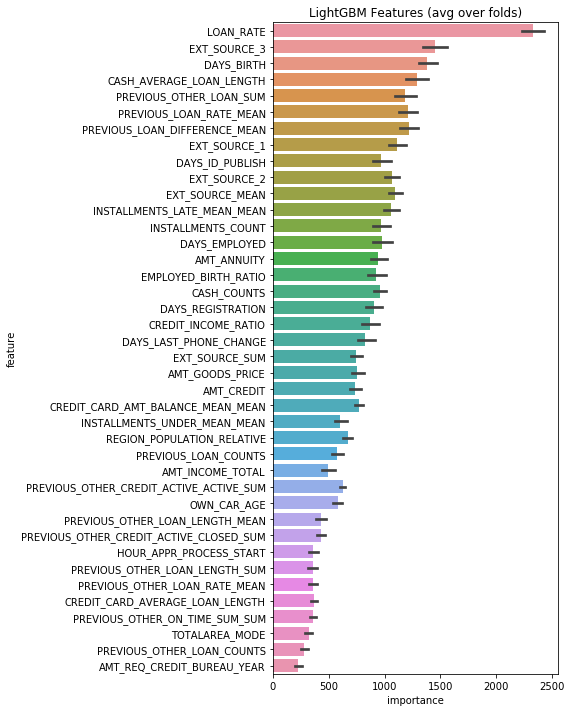

In [66]:
kfold_lightgbm(app, num_folds= 10, stratified= False, debug= False)